In [1]:
import pandas as pd
import numpy as np
from itertools import product
from ast import literal_eval
import seaborn as sns
import random
import matplotlib.pyplot as plt
import geopandas as gp
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import tqdm
import matplotlib.colors as mcolors
from funding import core

In [2]:
pubs_path="/u/miaoli/ember_home/dropbox/NationalFunding/Data/DerivedData/CleanedRawData/pub.pkl"
region_path="/u/miaoli/ember_home/dropbox/NationalFunding/Data/AdditionalData/cntry_region.xlsx"
world_geo_path="/u/miaoli/ember_home/dropbox/NationalFunding/Data/AdditionalData/world_map_shp/ne_50m_admin_0_countries.shp"

funding_intensity_overall_path = "/u/miaoli/ember_home/dropbox/NationalFunding/Figs/Figs/funding_intensity_overall.pdf"
funding_portfolio_path = "/u/miaoli/ember_home/dropbox/NationalFunding/Figs/Figs/funding_portfolio_region.pdf"
funding_portfolio_outlier = "/u/miaoli/ember_home/dropbox/NationalFunding/Figs/Figs/funding_portfolio_outlier.csv"
funding_intensity_self_path = "/u/miaoli/ember_home/dropbox/NationalFunding/Figs/Figs/country_exclusive_funding.pdf"

In [3]:
pubs_df=pd.read_pickle(pubs_path)
pubs_df.head()

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol,cofund,intfund
0,60694041,2017,9,1,"[Canada, United States]","[United States, United States]","[Canada, United States]",[United States],1,1,0,0
1,48573156,2012,89,1,[France],Not-Funded,[France],Not-Funded,0,0,0,0
2,55323671,2015,89,1,"[France, Chile]","[Chile, Chile, Chile, Chile, Chile]","[France, Chile]",[Chile],1,1,0,0
3,57633115,2016,31,1,"[Switzerland, United States]",[Switzerland],"[Switzerland, United States]",[Switzerland],1,1,0,0
4,64831413,2018,99,1,[China],"[China, China, China, China, China, China]",[China],[China],1,0,0,0


In [4]:
region=pd.read_excel(region_path)
region=region[['cntry','region2']].drop_duplicates()
region=region.rename(columns={'region2':'region'})
region=region.replace(to_replace={'region':{'EU':'Europe','Other Europe':'Europe'}})
region.head(2)

,cntry,region
0,Algeria,Africa
1,Angola,Africa


### measure and plot the overall funding intensity of countries across continents

In [5]:
funded=pubs_df[['author_distinct','funded']]
funded=funded.explode('author_distinct')
funded=funded.groupby(['author_distinct','funded']).size().reset_index(name='count')
funded=funded.pivot_table(index='author_distinct',columns='funded',values='count')
funded=funded.div(funded.sum(axis=1), axis=0).reset_index()
funded=funded.rename(columns={'author_distinct':'cntry',0:'not',1:'funded'})

In [6]:
funded=funded.merge(region,on='cntry')
funded.head()

,cntry,not,funded,region
0,Afghanistan,0.551378,0.448622,Asia
1,Albania,0.742275,0.257725,Europe
2,Algeria,0.772406,0.227594,Africa
3,Andorra,0.492754,0.507246,Europe
4,Angola,0.400415,0.599585,Africa


In [7]:
world_geo=core.read_geofile(world_geo_path)

In [8]:
funded[funded.funded>0.85]

,cntry,not,funded,region
43,Crimea,NaN,1.000000,Europe
133,Niue,NaN,1.000000,Oceania
157,Sao Tome & Principe,0.138889,0.861111,Africa


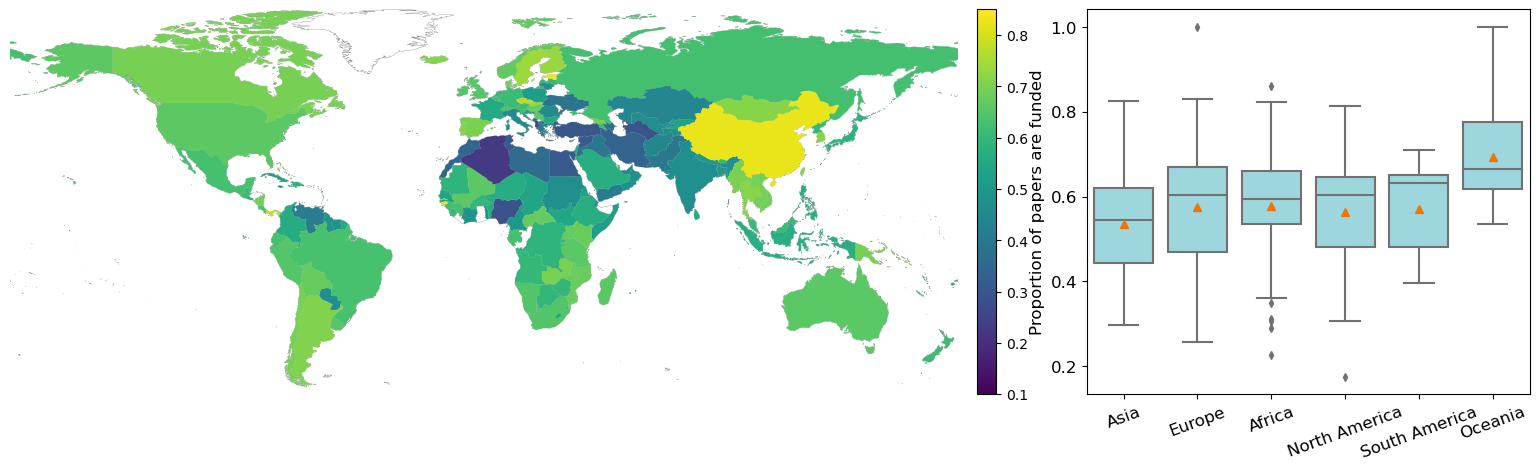

In [22]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [70, 30],'wspace': 0.1},figsize=(20,5))
plot_data=world_geo.merge(funded,left_on='WoS',right_on='cntry')
plot_data=gp.GeoDataFrame(plot_data)
core.plot_worldmap(ax[0], fig, world_geo, plot_data, 'funded','viridis',0.1,0.85)
ax[0].margins(0)

sns.boxplot(x='region',y='funded',data=funded,color='#92DFE6',
            order=['Asia','Europe','Africa','North America','South America','Oceania'],
            fliersize=4,
            ax=ax[1],
           showmeans=True,meanprops={"markerfacecolor":"#F27405", "markeredgecolor":"#F27405"})
ax[1].set_ylabel('Proportion of papers are funded',fontsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlabel('')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 20)
plt.savefig(funding_intensity_overall_path,bbox_inches='tight')

### calculate the funding portofolio of countres

In [23]:
pubs_df.head()

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol,cofund,intfund
0,60694041,2017,9,1,"[Canada, United States]","[United States, United States]","[United States, Canada]",[United States],1,1,0,0
1,48573156,2012,89,1,[France],Not-Funded,[France],Not-Funded,0,0,0,0
2,55323671,2015,89,1,"[France, Chile]","[Chile, Chile, Chile, Chile, Chile]","[Chile, France]",[Chile],1,1,0,0
3,57633115,2016,31,1,"[Switzerland, United States]",[Switzerland],"[Switzerland, United States]",[Switzerland],1,1,0,0
4,64831413,2018,99,1,[China],"[China, China, China, China, China, China]",[China],[China],1,0,0,0


In [9]:
author_df=pubs_df[['id','author_distinct','funder_distinct']].explode('author_distinct')
author_df.head()

,id,author_distinct,funder_distinct
0,60694041,Canada,[United States]
0,60694041,United States,[United States]
1,48573156,France,Not-Funded
2,55323671,France,[Chile]
2,55323671,Chile,[Chile]


In [58]:
region=pd.read_excel(region_path)
region=region[['cntry','region2']].drop_duplicates()
region=region.rename(columns={'region2':'region'})
region=region.replace(to_replace={'region':{'EU':'Europe','Other Europe':'Europe'}})

In [29]:
eucntrys = region[region.region=='EU'].cntry.values.tolist()

In [53]:
def assign_type(acntry,funders):
    t='null'
    if funders=='Not-Funded':
        t='No-Fund-Inf'
    elif len(funders)==1 and funders[0]==acntry: #if the author country is the only one funder of the pub
        t='Domestic'
    elif acntry in funders:
        t='Co-Funded'
    elif acntry in eucntrys and 'EU' in funders:
        t='Co-Funded'
    elif acntry not in funders:
        t='Foreign'
    return t
author_df['fund']=author_df.apply(lambda x: assign_type(x.author_distinct,x.funder_distinct),axis=1)

#### normalize the country's funding portfolio

In [54]:
fundtype=author_df.groupby(['author_distinct','fund']).size().reset_index(name='count')
fundtype=fundtype.pivot_table(index='author_distinct',columns='fund',values='count',fill_value=0)
fundtype = fundtype.div(fundtype.sum(axis=1), axis=0)
fundtype = fundtype.reset_index().melt(id_vars='author_distinct',var_name='fund', value_name='count')

In [59]:
fundtype=fundtype.merge(region,left_on='author_distinct',right_on='cntry',how='left')

In [60]:
fundtype=fundtype.dropna()#drop antarctica

In [61]:

def plot_region(df,region,ax,ylabel=0):
    order=['No-Fund-Inf','Domestic','Co-Funded','Foreign']
    palette=['#C5C9C7','#D96C89','#F08987','#EB7549']
    df=df[df.region==region]
    sns.boxplot(data=df,x='count',y='fund',
                order=order,palette=palette,saturation=0.5,width=0.5,
                linewidth=0.6,fliersize=3,ax=ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(label=region, fontdict={'fontsize':12})
    ax.set_xticks([])
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim(0,1.01)
    if ylabel==0:
        ax.set_yticks([])
    return ax


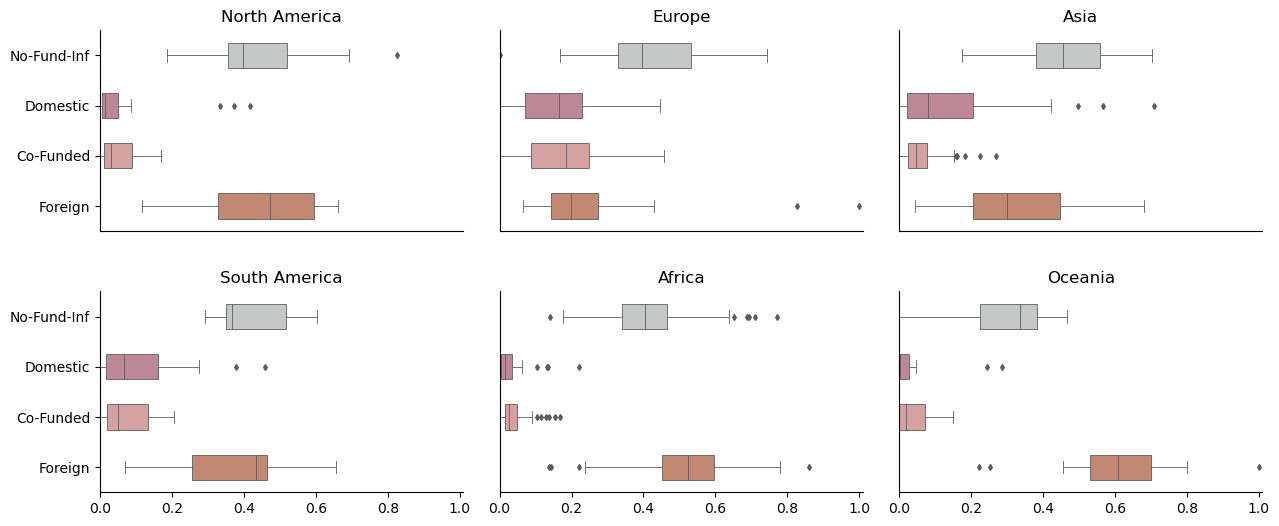

In [62]:
fig,ax=plt.subplots(nrows=2,ncols=3,figsize=(15,6))
plt.subplots_adjust(wspace=0.1,hspace=0.3)

ax0=plot_region(fundtype,'North America',ax[0][0],1)
ax1=plot_region(fundtype,'Europe',ax[0][1])
ax2=plot_region(fundtype,'Asia',ax[0][2])
ax3=plot_region(fundtype,'South America',ax[1][0],1)
ax3.set_xticks(np.arange(0,1.2,0.2))
ax4=plot_region(fundtype,'Africa',ax[1][1])
ax4.set_xticks(np.arange(0,1.2,0.2))
ax5=plot_region(fundtype,'Oceania',ax[1][2])
ax5.set_xticks(np.arange(0,1.2,0.2))
plt.savefig(funding_portfolio_path,bbox_inches='tight')

### generate a table print out the funding situation for outliear countries

In [63]:
def find_outliers_IQR(df):
    q1 = df['count'].quantile(0.25)
    q3 = df['count'].quantile(0.75)
    IQR = q3-q1
    outliers = df[((df['count']<(q1-1.5*IQR))|(df['count']>(q3+1.5*IQR)))]['author_distinct'].tolist()
    return outliers

In [64]:
#select outliers by region
regionlist = fundtype.region.unique()
outlierlist = []
for region in regionlist:
    outliers = find_outliers_IQR(fundtype[(fundtype.region==region)&(fundtype.fund=='Domestic')])
    outlierlist = outlierlist+outliers

In [65]:
outlier_fundtype = fundtype[fundtype.author_distinct.isin(outlierlist)]
outlier_fundtype = outlier_fundtype.pivot_table(index=['cntry','region'],columns=['fund'],values='count')
def format_decimal(cell_value):
    return f"{cell_value:.2f}"
outlier_fundtype = outlier_fundtype.applymap(format_decimal).reset_index()
outlier_fundtype.sort_values(by='region').to_csv(funding_portfolio_outlier, index=False)

### plot the ratio of self-funding

In [26]:
selfund=fundtype.pivot(index=['cntry','region'],columns='fund',values='count').reset_index()
selfund['Funded']=1-selfund['No-Funding']
selfund['DofF']=selfund['Domestic']/selfund['Funded'] #among the funded papers, the proportion that are exclusively funded by the country

In [34]:
selfund[selfund.cntry.isin(['China','United States'])]

fund,cntry,region,Co-Fund,Domestic,Foreign,Not-Funded,Funded,DofF
37,China,Asia,0.073513,0.709135,0.043017,0.174335,0.825665,0.858865
195,United States,North America,0.126083,0.417558,0.118039,0.338319,0.661681,0.631057


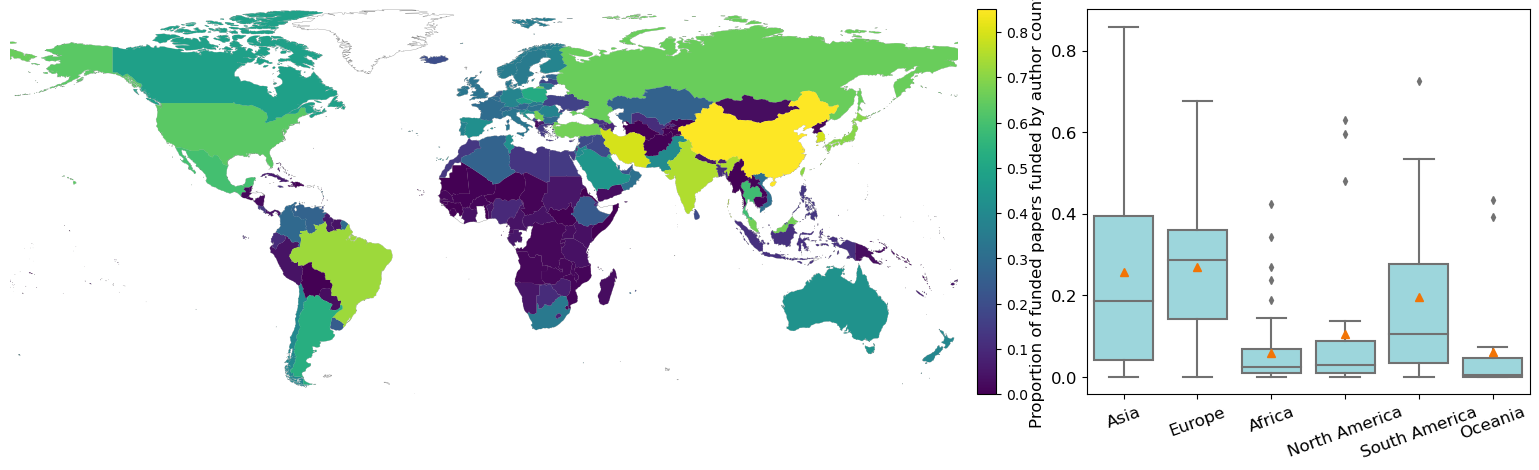

In [35]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [70, 30],'wspace': 0.1},figsize=(20,5))
plot_data=world_geo.merge(selfund,left_on='WoS',right_on='cntry')
plot_data=gp.GeoDataFrame(plot_data)
core.plot_worldmap(ax[0],fig, world_geo, plot_data, 'DofF','viridis',0.0,0.85)
ax[0].margins(0)

sns.boxplot(x='region',y='DofF',data=selfund,color='#92DFE6',
            order=['Asia','Europe','Africa','North America','South America','Oceania'],
            fliersize=4,
            ax=ax[1],
           showmeans=True,meanprops={"markerfacecolor":"#F27405", "markeredgecolor":"#F27405"})
ax[1].set_ylabel('Proportion of funded papers funded by author country',fontsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlabel('')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 20)
plt.savefig(funding_intensity_self_path,bbox_inches='tight')